In [1]:
from pyawd import VectorAcousticWaveDataset2D, VectorAcousticWaveDataset3D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import tsfresh
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
import pandas as pd

sns.set_theme()

In [2]:
train_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/train_small2D")
train_dataset._display_velocity_model = True
X = np.load("../../../local/datasets/AWD/train_small2D_interrogators_data.npy")
X = X[:, 0, :, :, :]
Y = np.load("../../../local/datasets/AWD/train_small2D_epicenters.npy")
test_dataset = VectorAcousticWaveDataset2D.load("../../../local/datasets/AWD/test_small2D")
test_dataset._display_velocity_model = True
X_test = np.load("../../../local/datasets/AWD/test_small2D_interrogators_data.npy")
X_test = X_test[:, 0, :, :, :]
Y_test = np.load("../../../local/datasets/AWD/test_small2D_epicenters.npy")

In [3]:
def make_df(X):
    a = []
    b = []
    c = []
    d = []
    e = []
    f = []
    for i in range(X.shape[0]):
        for j in range(X.shape[-1]):
            a.append(i)
            b.append(j*train_dataset.ddt)
            c.append(X[i, 0, 0, j])
            d.append(X[i, 0, 1, j])
            e.append(X[i, 1, 0, j])
            f.append(X[i, 1, 1, j])
    df = pd.DataFrame()
    df["id"] = a
    df["time"] = b
    df["x0"] = c
    df["y0"] = d
    df["x1"] = e
    df["y1"] = f
    return df

In [4]:
Y = Y[:, 1]
Y_test = Y_test[:, 1]

In [13]:
size = 10
df, df_test = make_df(X[:size]), make_df(X_test[:size])

In [15]:
train = tsfresh.extract_features(df, column_id="id", column_sort="time", 
                                 default_fc_parameters=EfficientFCParameters(), n_jobs=16).dropna(axis=1)

Feature Extraction:   0%|                                                                                                                                                                    | 0/40 [00:09<?, ?it/s]Traceback (most recent call last):

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 132, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/__init__.py", line 27, in <module>
    from tsfresh.convenience.relevant_extraction import (  # noqa: E402
  File "/Library/Frameworks/Python.framework/Versions/

KeyboardInterrupt: 

In [ ]:
test = tsfresh.extract_features(df_test, column_id="id", column_sort="time", 
                                default_fc_parameters=EfficientFCParameters(), n_jobs=8).dropna(axis=1)

In [ ]:
print("Training size:", train.shape)
print("Testing size:", test.shape)

Process SpawnPoolWorker-53:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
                    ^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/utilities/distribution.py", line 43, in _function_with_partly_reduce
    results = list(itertools.chain.from_iterable(results))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tsfresh/utilities/distribution.py", line 42, in <genexpr>

In [38]:
train_features = train
test_features = test

In [141]:
train_features_numeric = train_features.select_dtypes(include=[np.number])
test_features_numeric = test_features.select_dtypes(include=[np.number])

In [142]:
train_targets = Y
test_targets = Y_test

In [143]:
def normalize(df):
    min_df = df.min()
    max_df = df.max()
    return (df-min_df)/(max_df-min_df)

In [144]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_features_numeric)

In [145]:
normalized_train_features_numeric = scaler.transform(train_features_numeric)
normalized_train_targets = normalize(train_targets)
normalized_test_features_numeric = scaler.transform(test_features_numeric)
normalized_test_targets = normalize(test_targets)

In [146]:
print("Numeric features:", len(train_features_numeric.columns))

Numeric features: 40


In [147]:
print("Minimal target:", np.min(normalized_train_targets))
print("Maximal target:", np.max(normalized_train_targets))
print("Mean target:", np.mean(normalized_train_targets))
print("Median target:", np.median(normalized_train_targets))

Minimal target: 0.0
Maximal target: 1.0
Mean target: 0.4976903225806451
Median target: 0.4838709677419355


## Error function

In [148]:
def rmse(y, y_hat):
    return np.mean((y-y_hat)**2)**0.5

## Linear Regression

In [149]:
from sklearn.linear_model import LinearRegression

In [150]:
linear_model = LinearRegression().fit(normalized_train_features_numeric, normalized_train_targets)

In [151]:
%%capture lm_res
print("RMSE Linear Model:", rmse(normalized_test_targets, linear_model.predict(normalized_test_features_numeric)))

## Neural Network

In [152]:
from sklearn.neural_network import MLPRegressor

In [153]:
mlp_regressor = MLPRegressor(solver='adam',
                             activation='logistic',
                             hidden_layer_sizes=(32, 16, 8),
                             max_iter=10000,
                             learning_rate_init=0.01
                            ).fit(normalized_train_features_numeric, normalized_train_targets)

In [154]:
%%capture nn_res
print("RMSE Neural Network:", rmse(normalized_test_targets, mlp_regressor.predict(normalized_test_features_numeric)))

## SGD

In [155]:
from sklearn.linear_model import SGDRegressor

In [156]:
sgd = SGDRegressor(loss="squared_error", penalty="l2").fit(normalized_train_features_numeric, normalized_train_targets)

In [157]:
%%capture sgd_res
print("RMSE SGD:", rmse(normalized_test_targets, sgd.predict(normalized_test_features_numeric)))

## Support Vector Machines

In [158]:
from sklearn import svm

In [159]:
svm = svm.SVR().fit(normalized_train_features_numeric, normalized_train_targets)

In [160]:
%%capture svm_res
print("RMSE SVM:", rmse(normalized_test_targets, svm.predict(normalized_test_features_numeric)))

## PLS regression

In [161]:
from sklearn.cross_decomposition import PLSRegression

In [162]:
pls2 = PLSRegression(n_components=2).fit(normalized_train_features_numeric, normalized_train_targets)

In [163]:
%%capture pls_res
print("RMSE PLS:", rmse(normalized_test_targets, pls2.predict(normalized_test_features_numeric)))

## Decision Tree

In [164]:
from sklearn import tree

In [165]:
dt = tree.DecisionTreeRegressor().fit(normalized_train_features_numeric, normalized_train_targets)

In [166]:
%%capture dt_res
print("RMSE Decision Tree:", rmse(normalized_test_targets, dt.predict(normalized_test_features_numeric)))

## Random Forest

In [167]:
from sklearn.ensemble import RandomForestRegressor

In [168]:
rf = RandomForestRegressor().fit(normalized_train_features_numeric, normalized_train_targets)

In [169]:
%%capture rf_res
print("RMSE Random Forest:", rmse(normalized_test_targets, rf.predict(normalized_test_features_numeric)))

## AdaBoost

In [170]:
from sklearn.ensemble import AdaBoostRegressor

In [171]:
ada_boost = AdaBoostRegressor().fit(normalized_train_features_numeric, normalized_train_targets)

In [172]:
%%capture ada_res
print("RMSE Ada Boost:", rmse(normalized_test_targets, ada_boost.predict(normalized_test_features_numeric)))

## Results

In [173]:
print(lm_res, end="")
print(nn_res, end="")
print(sgd_res, end="")
print(svm_res, end="")
print(pls_res, end="")
print(dt_res, end="")
print(rf_res, end="")
print(ada_res, end="")

RMSE Linear Model: 0.18334547357329123
RMSE Neural Network: 0.09998960884673
RMSE SGD: 0.19010428274957322
RMSE SVM: 0.10866247257970407
RMSE PLS: 0.21257724742395762
RMSE Decision Tree: 0.11784573418480922
RMSE Random Forest: 0.0758027658678455
RMSE Ada Boost: 0.12809995950707795


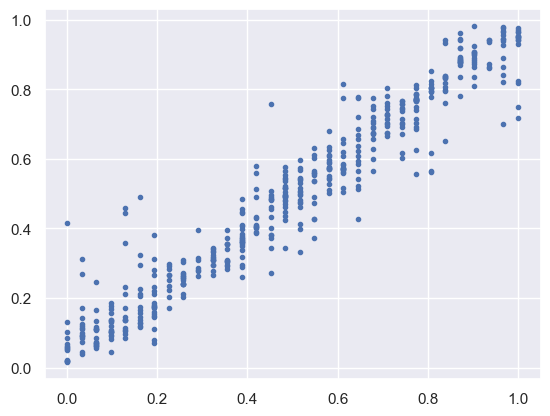

In [174]:
plt.scatter(normalized_test_targets, rf.predict(normalized_test_features_numeric), marker='.')